This notebook provides an example of the difficulties that humans exhibit in distinguishing random from nonrandom outcomes.

In [1]:
import numpy
import matplotlib.pyplot as plt

import scipy.stats
%matplotlib inline


First we define a function to generate a random series of free throws with a particular likelihood of success.  We also provide the ability to generate a series that is streakier than random (using an autoregressive process) or one that is less streaky than random (by randomly inserting switches in the timeseries). 

In [97]:
def mk_random(nshots,psuccess=0.5,ar=0.0,pswitch=0,require_p=False):
    assert not (ar>0 and pswitch>0)
    assert ar>=0 and ar<=1
    assert pswitch>=0 and pswitch<=1

    if ar==0 and pswitch==0:
        r=numpy.random.rand(nshots)
    
    elif ar>0:
        # generate random timeseries using autoregressive model
        r=numpy.zeros(nshots)
        r[0]=numpy.random.rand()
        for i in range(1,nshots):
            r[i]=r[i-1]*ar + numpy.random.rand()*(1-ar)
            # make sure it's within bounds
            if r[i]>1:
                r[i]=1
            elif r[i]<0:
                r[i]=0
    else:
        # generate "super-random" series by flipping 
        r=numpy.zeros(nshots)
        r[0]=numpy.random.rand()
        for i in range(1,nshots):
            if numpy.random.rand()<pswitch:
                r[i]=numpy.abs(1-r[i-1])
            else:
                r[i]=numpy.random.rand()

    if require_p:
        # use percentile to ensure that the proportion of successes is always the same
        psuccess=scipy.stats.scoreatpercentile(r,psuccess*100)
    return (r<psuccess).astype('int')

# define a function to compute run lengths
# adapted from http://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) 
            RP: edited to just return runlengths"""
        ia = numpy.array(inarray)                  # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = numpy.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
            i = numpy.append(numpy.where(y), n - 1)   # must include last element posi
            z = numpy.diff(numpy.append(-1, i))       # run lengths
            p = numpy.cumsum(numpy.append(0, z))[:-1] # positions
            return z   

Generate a large number of sequences, and get the histogram of run lengths

In [148]:
nruns=10000
nshots=25
runlengths_rand=[]
data_rand=[]
for i in range(nruns):
    s=mk_random(nshots,0.5)
    for l in rle(s):
        runlengths_rand.append(l)
    data_rand.append(s)
        
runlengths_rand=numpy.array(runlengths_rand)

runlengths_ar=[]
data_ar=[]
for i in range(nruns):
    s=mk_random(nshots,0.5,ar=0.5)
    for l in rle(s):
        runlengths_ar.append(l)
    data_ar.append(s)

        
runlengths_ar=numpy.array(runlengths_ar)

runlengths_switch=[]
data_switch=[]
for i in range(nruns):
    s=mk_random(nshots,0.5,pswitch=0.5)
    for l in rle(s):
        runlengths_switch.append(l)
    data_switch.append(s)

        
runlengths_switch=numpy.array(runlengths_switch)




exponential fit to random: lambda = 0.685, r2 = 0.99905
exponential fit to ar: lambda = 0.769, r2 = 0.97556
exponential fit to super-random: lambda = 0.647, r2 = 0.89684


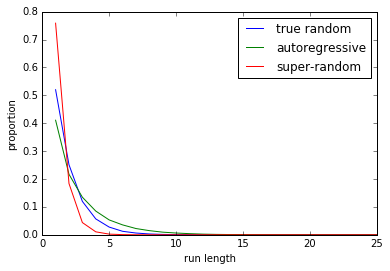

In [149]:
bins=numpy.arange(0.5,nshots+1.5,1)
h_rand,_=numpy.histogram(runlengths_rand,bins=bins,normed=True)
h_ar,_=numpy.histogram(runlengths_ar,bins=bins,normed=True)
h_switch,_=numpy.histogram(runlengths_switch,bins=bins,normed=True)


plt.plot(bins[:-1]+0.5,h_rand)
plt.plot(bins[:-1]+0.5,h_ar,'green')
plt.plot(bins[:-1]+0.5,h_switch,'red')

from scipy.optimize import curve_fit

def func(x, b):
    return numpy.exp(-b * x)
def powerlaw(x,a):
    return a * x**(a-1)

x=bins[:-1]+0.5
popt_total, pcov = curve_fit(func, x, h_rand)
print('exponential fit to random: lambda = %0.3f, r2 = %0.5f'%(popt_total[0],numpy.corrcoef(func(x, *popt_total),h_rand)[0,1]**2))
popt_total, pcov = curve_fit(func, x, h_ar)
print('exponential fit to ar: lambda = %0.3f, r2 = %0.5f'%(popt_total[0],numpy.corrcoef(func(x, *popt_total),h_ar)[0,1]**2))
popt_total, pcov = curve_fit(func, x, h_switch)
print('exponential fit to super-random: lambda = %0.3f, r2 = %0.5f'%(popt_total[0],numpy.corrcoef(func(x, *popt_total),h_switch)[0,1]**2))


plt.ylabel('proportion')
plt.xlabel('run length')
plt.legend(['true random','autoregressive','super-random'])

Let's see how well we can detect runs using the standard statistical approach.  

In [150]:
def runs_test(series):
    # based on http://www.itl.nist.gov/div898/handbook/eda/section3/eda35d.htm
    runs=rle(series)
    r=numpy.sum(numpy.array(runs)>1)
    if r<1:
        return 1.0
    n0=numpy.sum(series==0)
    n1=numpy.sum(series==1)
    r_bar=((2*n0*n1)/(n0 + n1)) + 1
    s2_bar=((2*n0*n1)*(2*n0*n1 - n0 -n1))/((n0 + n1 - 1)*((n0+n1)**2))
    assert s2_bar > 0.
    z=(r - r_bar)/s2_bar
    p=1.0 - scipy.stats.norm.cdf(numpy.abs(z))
    #print(r,r_bar,s2_bar,z,p)
    return p


In [151]:
runstest_rand=[]
badctr_rand=0
for i in range(nruns):
    try:
        runstest_rand.append(runs_test(data_rand[i]))
    except:
        badctr_rand+=1
        
runstest_ar=[]
badctr_ar=0
for i in range(nruns):
    try:
        runstest_ar.append(runs_test(data_ar[i]))
    except:
        badctr_ar+=1
        
runstest_switch=[]
badctr_switch=0
for i in range(nruns):
    try:
        runstest_switch.append(runs_test(data_switch[i]))
    except:
        badctr_switch+=1

In [152]:
print('Probability of rejecting null hypothesis of random generation:')
print('rand: %0.3f'%numpy.mean(numpy.array(runstest_rand)<0.05))
print('ar: %0.3f'%numpy.mean(numpy.array(runstest_ar)<0.05))
print('super-random: %0.3f'%numpy.mean(numpy.array(runstest_switch)<0.05))



Probability of rejecting null hypothesis of random generation:
rand: 0.040
ar: 0.165
super-random: 0.234
